# Homework 4: Analyzing Rates of Sea Level Rise
In this homework, you'll investigate sea level change using data from the ECCO state estimate. You'll look at spatial differences over the past few decades and then compare how sea level on the California coast compares to the global mean.

Begin by importing the modules you'll need for this notebook:

In [148]:
# import packages here
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc4
import os


import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cm
import moviepy.video.io.ImageSequenceClip

## Part 1: Download Sea Surface Height Data
To begin this exercise, download all of the available sea surface height data (1992-2017) from the ECCO Version 4 Release 4 output. There are several different variables for sea surface height pertaining to different components and corrections. In this homework, we'll use the `SSHDYN` variable which is equivalent to what satellites would measure from space.

To obtain the data, use the [Downloading ECCO Data](https://github.com/ProfMikeWood/ocean_modeling_book/blob/main/tools/Downloading%20ECCO%20Data.ipynb) notebook provided with the course notes.

In [149]:
# define the path to the folder where the SSH data has been download on your machine
ssh_folder = '/Users/johnathonlu/Documents/SJSU/cs185c_spring2025/Data'

## Part 2: Plot Total Sea Level Rise 1992-2017
As a first look into how sea level has changed in the past several decades, we'll look at the differences between two time periods at the beginning and end of the available model output: January 1992 and January 2017. It is important to use the same month because variations in sea level also have a seasonal cycle (as we'll see below). Begin by reading in the data:

In [150]:
# items = os.listdir(ssh_folder)
# print(items)

In [151]:
# read in the longitude, latitude, and model ssh grid in January 1992 (SSHDYN_1992_01.nc)
# read in the data
file_name = os.path.join(ssh_folder,'ECCO','Version4','Release4',
                          'interp_monthly','SSHDYN','SSHDYN_1992_01.nc')
ds = xr.open_dataset(file_name, decode_times = False)
longitude = np.array(ds['longitude'][:])
latitude = np.array(ds['latitude'][:])
SSHDYN_1992 = np.array(ds['SSHDYN'][0, :, :])
ds.close()

# read in the model ssh grid in January 2017 (SSHDYN_2017_01.nc)
file_name = os.path.join(ssh_folder,'ECCO','Version4','Release4',
                          'interp_monthly','SSHDYN','SSHDYN_2017_01.nc')
ds = xr.open_dataset(file_name, decode_times = False)

SSHDYN_2017 = np.array(ds['SSHDYN'][0, :, :])
ds.close()
ds

<xarray.Dataset> Size: 2MB
Dimensions:    (i: 720, j: 360, time: 1, nv: 2)
Coordinates:
  * i          (i) int64 6kB 0 1 2 3 4 5 6 7 ... 712 713 714 715 716 717 718 719
  * j          (j) int64 3kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
  * time       (time) int64 8B 0
    latitude   (j) float64 3kB ...
    longitude  (i) float64 6kB ...
    timestep   (time) int64 8B ...
    time_bnds  (time, nv) int64 16B ...
Dimensions without coordinates: nv
Data variables:
    SSHDYN     (time, j, i) float64 2MB ...
Attributes: (12/20)
    product_time_coverage_start:  1992-01-01T12:00:00
    author:                       Ou Wang and Ian Fenty
    Insitution:                   JPL
    product_version:              ECCO Version 4 Release 4
    time_units:                   days since 1992-01-01 00:00:00
    Conventions:                  CF-1.6
    ...                           ...
    nz:                           1
    geospatial_vertical_units:    meter
    geospatial_vertical_max:      0
    date_created:                 Wed Oct 23 23:08:15 2019
    time_coverage_start:          2017-01-01T00:00:00
    time_coverage_end:            2017-02-01T00:00:00

Now, make a plot of the difference between January 2017 and January 1992. Be sure to add a colorbar with a divergent colormaps and set the color bounds to be equal in the positive and negative directions.

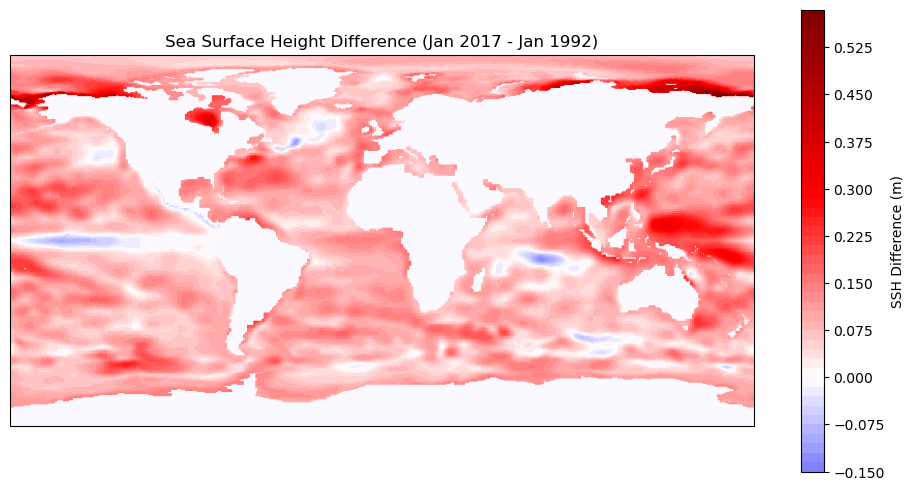

In [152]:
# make a plot of the differences between 2017 and 1992
# Compute SSH difference
ssh_diff = SSHDYN_2017 - SSHDYN_1992

# Determine color bounds
cmax = np.max(np.abs(ssh_diff))

# Plot SSH difference
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(longitude, latitude, ssh_diff, levels=50, cmap='seismic', 
             vmin=-cmax, vmax=cmax, transform=ccrs.PlateCarree())

ax.set_title("Sea Surface Height Difference (Jan 2017 - Jan 1992)")
cbar = plt.colorbar()
cbar.set_label("SSH Difference (m)")

plt.show()



### Questions:
Where are the largest increases in sea level observed between these two time periods? Are there any locations on the globe where sea level has fallen? If so, where?

Answer: The largest increases of SSH seem to be located above Russia and Canada/Alaska. The SSH falls around the equator more noticeably and some parts of greenland and below australia.

## Part 3: Create a Timeseries of Sea Surface Height in California
Next, we'll make a timeseries of sea surface height at a point off the California coast near San José. A close location in the model is at 37$^{\circ}$N, 122$^{\circ}$W. Begin by finding the closest row and column in the model grid to this longitude and latitude.

In [153]:
# define the latitude and longitude
lon = -122
lat = 37

# find the row and column closest to the location of the point off the CA coast
# note that you have already read in the longitude and latitude if the grid to make the plot above
lon_index = np.argmin(np.abs(longitude - (-122)))
lat_index = np.argmin(np.abs(latitude - (37)))

Now, armed with your sample location, loop through each sea surface height file to make a timeseries of sea level rise between 1992 and 2017. Every time you access a file, sample the model grid at the row and column you identified above.

In [154]:
# create a timeseries of ssh at the point above by looping through all of the ssh files
# each time through the loop, sample the ssh grid at the row and column identified above
# your timeseries should be an (N,2) array with time in the first column and ssh values in the second

# make a list to contain the file names
file_list = []

# loop through the 12 months
for year in range(1992,2017+1):
    for month in range(1,13):
        yr = str(year)
        mo = '{:02d}'.format(month)
        file_name = 'SSHDYN' + '_' + yr + '_' + mo + '.nc'
        file_list.append(file_name)
# print out the file names
# print(file_list)

# file_name = os.path.join(ssh_folder,'ECCO','Version4','Release4', 'interp_monthly','SSHDYN','SSHDYN_1992_01.nc')

In [167]:
ssh_values = []
months = 1992
# loop through each file
for file_name in file_list:
    
    # identify path to the data file
    file_name = os.path.join(ssh_folder,'ECCO','Version4','Release4', 'interp_monthly','SSHDYN',file_name)
    
    # read in the data 
    ds = xr.open_dataset(file_name)
    ssh = np.array(ds['SSHDYN'][:])
    
    sshdyn = ssh[0, lat_index, lon_index]
    ssh_values.append([months,sshdyn])
    months = months + (1/12)

# convert list to a numpy array
ssh_values = np.array(ssh_values)

# print out the temperature values as a sanity check
print(ssh_values)

[[1.99200000e+03 1.88043118e-01]
 [1.99208333e+03 2.37152606e-01]
 [1.99216667e+03 2.44106546e-01]
 [1.99225000e+03 2.14680240e-01]
 [1.99233333e+03 1.87756598e-01]
 [1.99241667e+03 1.68227851e-01]
 [1.99250000e+03 1.89466134e-01]
 [1.99258333e+03 1.83576778e-01]
 [1.99266667e+03 2.01717332e-01]
 [1.99275000e+03 2.40106121e-01]
 [1.99283333e+03 2.34525606e-01]
 [1.99291667e+03 2.28738725e-01]
 [1.99300000e+03 2.31779844e-01]
 [1.99308333e+03 2.46841580e-01]
 [1.99316667e+03 2.21908808e-01]
 [1.99325000e+03 1.74462438e-01]
 [1.99333333e+03 1.34788901e-01]
 [1.99341667e+03 1.43908605e-01]
 [1.99350000e+03 1.66291237e-01]
 [1.99358333e+03 2.06437692e-01]
 [1.99366667e+03 2.14129508e-01]
 [1.99375000e+03 2.30565608e-01]
 [1.99383333e+03 2.31256515e-01]
 [1.99391667e+03 2.37431496e-01]
 [1.99400000e+03 2.25643948e-01]
 [1.99408333e+03 2.11624578e-01]
 [1.99416667e+03 1.92501679e-01]
 [1.99425000e+03 1.44380525e-01]
 [1.99433333e+03 9.05755982e-02]
 [1.99441667e+03 8.49175528e-02]
 [1.994500

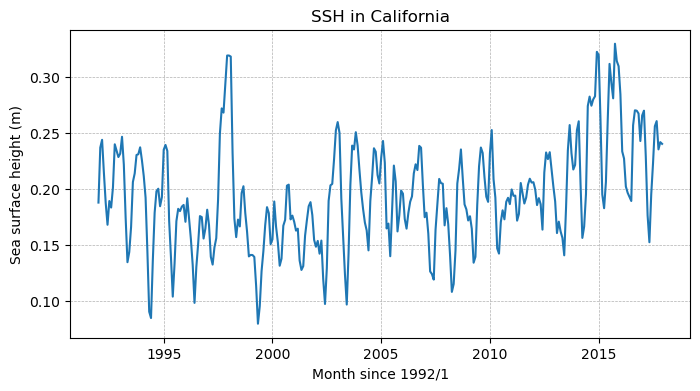

In [162]:
# make a plot of the ssh timeseries
fig = plt.figure(figsize=(8,4))
plt.plot(ssh_values[:, 0],ssh_values[:, 1])
plt.title('SSH in California')
plt.ylabel('Sea surface height (m)')
plt.xlabel('Month since 1992/1')
plt.grid(linestyle='--',linewidth=0.5)
plt.show()

## Part 4: Create a Timeseries of Global Mean Sea Surface Height
Next, make a timeseries of sea surface height averaged across the globe. Your loop should look quite similar to that above - you'll just need to make a slight change to average across the whole ocean rather than sampling at a single point.

In [163]:
# create a timeseries of the global mean ssh by looping through all of the ssh files
# each time through the loop, take the mean of the ssh grid at the row and column identified above
# when you take the mean, be sure to exclude 0 values, which pertain to land
# your timeseries should be an (N,2) array with time in the first column and ssh values in the second

# make a list to store the temperature values
ssh_values_globe = []
months = 1992

# loop through each file
for file_name in file_list:
    
    # identify path to the data file
    file_name = os.path.join(ssh_folder,'ECCO','Version4','Release4', 'interp_monthly','SSHDYN',file_name)
    
    # read in the data 
    ds = xr.open_dataset(file_name)
    ssh = np.array(ds['SSHDYN'][:])

    sshdyn = ssh[0, :, :]
    sshdyn = sshdyn[sshdyn != 0]
    ssh_values_globe.append([months, np.mean(sshdyn)])
    months = months + (1/12)
    
# convert list to a numpy array
ssh_values_globe = np.array(ssh_values_globe)

# print out the temperature values as a sanity check
# print(ssh_values_globe)


## Part 5: Compute Trends in Sea Surface Height
To compare the two timeseries, compute trends by fitting a line to each timeseries and examining the slope. Print out each trend in mm/yr, rounded to 2 decimal places. Note that the units of sea surface height are in meters.

[ 3.37681458e-03 -6.84047517e+00]


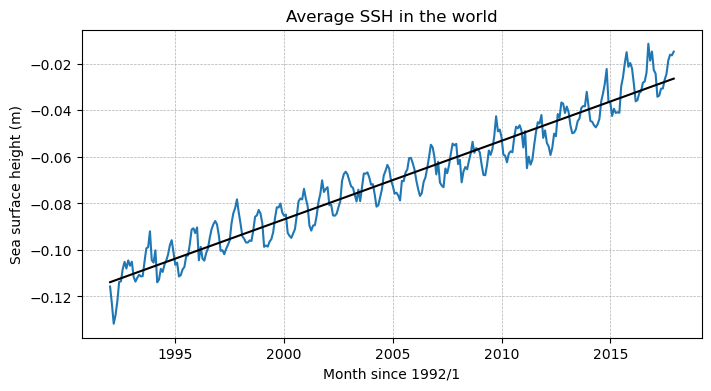

In [164]:
# compute the line coefficients
p = np.polyfit(ssh_values_globe[:,0], ssh_values_globe[:,1], 1)

# print the coefficients
print(p)

# sanity check: one is the slope and one is intercept - which is which?
slope = p[0]
intercept = p[1]

# print out the statistics in mm/yr for each timeseries
fig = plt.figure(figsize=(8,4))

# plot the data
plt.plot(ssh_values_globe[:,0], ssh_values_globe[:,1])

# plot the trend line
# k is shorthand for black and - is for a line.
# line is plotted using y=mx+b format
plt.plot(ssh_values_globe[:,0], slope * ssh_values_globe[:,0] + intercept, 'k-')

plt.title('Average SSH in the world')
plt.ylabel('Sea surface height (m)')
plt.xlabel('Month since 1992/1')
plt.grid(linestyle='--',linewidth=0.5)
plt.show()

### Question:
How does the trend in sea level rise in California compare to the global mean rate?

Answer: The overall trend shows an increase in both graphs but there is a larger differnce of amplitude in California's SSH as its just one spot where in the whole globe it's a lot less difference between each month and year. 

## Part 6: Plot the Timeseries of Sea Surface Height
Finally, plot the two timeseries on the same plot along with their trend lines. Be sure to label your axes and include a legend.

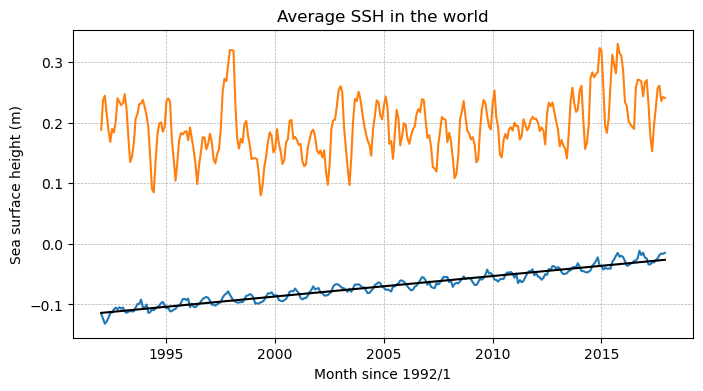

In [166]:
# create your plot here
fig = plt.figure(figsize=(8,4))

# plot the data
plt.plot(ssh_values_globe[:,0], ssh_values_globe[:,1])
plt.plot(ssh_values[:, 0],ssh_values[:, 1])

# plot the trend line
# k is shorthand for black and - is for a line.
# line is plotted using y=mx+b format
plt.plot(ssh_values_globe[:,0], slope * ssh_values_globe[:,0] + intercept, 'k-')

plt.title('Average SSH in the world')
plt.ylabel('Sea surface height (m)')
plt.xlabel('Month since 1992/1')
plt.grid(linestyle='--',linewidth=0.5)
plt.show()

### Questions:

How do the timeseries for Calfiornia and the global mean compare? Comment on their variability. What are the two highest years of sea level in California? What oceanographic phenomenon happened during this time?

Answer: The california timeseries has a higher average SSH and also has a higher variability in their graph. The highest years in California was 1998 and 2015. From a quick websearch, it seems that during these times, was the El Nino periods that happen every 7 years which bring higher levels of precipitation to the California Coast.